# Building a POC

2020-12 | Ludmila Exbrayat

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import time
import glob
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

In [29]:
data_dir = 'data/'

## Preparing dataset

In [30]:
img_transforms = transforms.Compose([transforms.Resize((224, 398)),
                                       transforms.ToTensor(),])

In [31]:
def load_split_sets(data_dir, valid_size = .2, test_size = .1):
    # Transforming the images (resizing)
    img_transforms = transforms.Compose([transforms.Resize((224, 398)),
                                         transforms.ToTensor(),])
    
    # Loading the images
    train_data = datasets.ImageFolder(data_dir,
                                      transform=img_transforms)
    valid_data = datasets.ImageFolder(data_dir,
                                      transform=img_transforms)
    test_data = datasets.ImageFolder(data_dir,
                                    transform=img_transforms)
    
    # Splitting the images
    num_examples = len(train_data)
    indices = list(range(num_examples))
    
    split_valid = int(np.floor((1 - valid_size - test_size) * num_examples))
    split_test = int(np.floor((1 - test_size) * num_examples))
    
    np.random.seed(0) # setting a seed so the sets don't change over time
    np.random.shuffle(indices)
    
    train_idx, valid_idx, test_idx = indices[:split_valid], indices[split_valid+1:split_test], indices[split_test+1:]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    trainloader = torch.utils.data.DataLoader(train_data,
                                              sampler=train_sampler, 
                                              batch_size=64)
    validloader = torch.utils.data.DataLoader(valid_data,
                                              sampler=valid_sampler, 
                                              batch_size=64)
    testloader = torch.utils.data.DataLoader(test_data,
                                             sampler=test_sampler, 
                                             batch_size=64)
    
    print('{num_train} images in training set'.format(num_train=len(trainloader.sampler.indices)))
    print('{num_valid} images in validation set'.format(num_valid=len(validloader.sampler.indices)))
    print('{num_test} images in test set'.format(num_test=len(testloader.sampler.indices)))
    
    return trainloader, validloader, testloader

In [32]:
trainloader, validloader, testloader = load_split_sets(data_dir, .2, .1)

1222 images in training set
348 images in validation set
174 images in test set


## Creating the model

Using a pre-trained model (resnet50)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "cpu")
model = models.resnet50(pretrained=True)
#print(model)

Freezing the pre-trained layers. Then, re-defining the final fully-connected layer. Creating the criterion (the loss function) and picking an optimizer (Adam in this case) and learning rate.

In [35]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                         nn.ReLU(),
                         nn.Dropout(0.2),
                         nn.Linear(512, 10),
                         nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training the model

Only the last layer will be trained

In [36]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, valid_losses = list(), list()
start = time.time()
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    valid_loss += batch_loss.item()

                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            valid_losses.append(valid_loss/len(validloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Valid loss: {valid_loss/len(validloader):.3f}.. "
                  f"Valid accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0
            model.train()
print('Trained in {time} seconds'.format(time = int(time.time() - start)))
torch.save(model, 'models/eggs_poc_{now}.pth'.format(now = int(time.time())))

Epoch 1/1.. Train loss: 2.009.. Valid loss: 1.412.. Valid accuracy: 0.625
Epoch 1/1.. Train loss: 0.821.. Valid loss: 1.068.. Valid accuracy: 0.615
Trained in 1073 seconds


## Evaluating the model

In [45]:
# Listing all models available
files_models = []
for file in glob.glob("models/*.pth"):
    files_models.append(file)
    print(file)
    

# Taking the last one
last_model = sorted(files_models)[-1]
print('Last model: {name}'.format(name = last_model))

models/eggs_poc_1610271716.pth
models/eggs_poc_1609231816.pth
models/eggs_poc_1609182820.pth
models/eggs_poc_1610274923.pth
Last model: models/eggs_poc_1610274923.pth


In [46]:
# Reloading the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(last_model)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
def predict_images(model, loader):
    
    pred_classes = torch.tensor([])
    true_classes = torch.tensor([])
    
    for inputs, classes in loader:
        
        start = time.time()

        # Passing the images through the model
        output = model.forward(inputs)
        print('Passed {num_images} images in the model in {time} seconds'.format(num_images = len(output), time = int(time.time() - start)))

        # Getting the exponential values of the output (WHY?)
        ps = torch.exp(output)

        # Inferring the resulting classes
        pred_classes = torch.cat((pred_classes, ps.max(dim=1)[1]))
        true_classes = torch.cat((true_classes, classes.data))
        
    return pred_classes, true_classes

In [48]:
def get_confusion_matrix(true_classes, pred_classes, loader):

    path_img = dict()
    
    all_paths = [loader.dataset.imgs[i] for i in loader.sampler.indices]

    # Getting the paths of the images in each category of the confusion matrix
    path_img['true_positive'] = [img[0] for (img, condition) in zip(all_paths, ((true_classes == 1) & (pred_classes == 1)).tolist()) if condition]
    path_img['false_positive'] = [img[0] for (img, condition) in zip(all_paths, ((true_classes == 0) & (pred_classes == 1)).tolist()) if condition]
    path_img['true_negative'] = [img[0] for (img, condition) in zip(all_paths, ((true_classes == 0) & (pred_classes == 0)).tolist()) if condition]
    path_img['false_negative'] = [img[0] for (img, condition) in zip(all_paths, ((true_classes == 1) & (pred_classes == 0)).tolist()) if condition]

    # Computing the confusion matrix
    confusion_matrix = pd.DataFrame({
     'pred_positive': [len(path_img['true_positive']), len(path_img['false_positive'])],
     'pred_negative': [len(path_img['false_negative']), len(path_img['true_negative'])],
    })

    confusion_matrix.index = ['class_positive', 'class_negative']

    return path_img, confusion_matrix

In [49]:
loader = testloader
pred_classes, true_classes = predict_images(model, loader)

Passed 64 images in the model in 29 seconds
Passed 64 images in the model in 26 seconds
Passed 46 images in the model in 17 seconds


In [50]:
path_img, confusion_matrix = get_confusion_matrix(true_classes, pred_classes, loader)

In [51]:
confusion_matrix

,pred_positive,pred_negative
class_positive,0,56
class_negative,0,118


So obviously this model is not working at the moment (it never predicts that there is an egg).

In [52]:
def predict_image(image):
    image_tensor = img_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [53]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=img_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

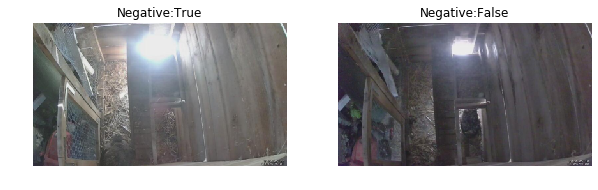

In [56]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(2)
fig = plt.figure(figsize=(10,10))
for ii in range(2):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(testloader.dataset.classes[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()